In [3]:
import torch
from hkey.nn import HKLinear, HKLinear2D

x = torch.rand(1, 256, 1024)

l = HKLinear(1024, 4096, n_clusters=32)
l.init_clusters()

y = l(x)

In [80]:
import torch
import torch.nn as nn
import torch.utils.benchmark as benchmark


x = torch.randn(1, 256, 8192) # B, N, C
layer = nn.Linear(8192, 8192*8)

t0 = benchmark.Timer(
    stmt='layer(x)',
    setup='from __main__ import torch',
    globals={'x': x, 'layer': layer},
    num_threads=torch.get_num_threads()
)

t0.timeit(10)

layer(x)
setup: from __main__ import torch
  1.18 s
  1 measurement, 10 runs , 6 threads

In [87]:
import torch
from modules import HKLinear, HKLinear2D
import torch.utils.benchmark as benchmark

x = torch.randn(1, 256, 8192) # B, N, C
layer = HKLinear2D(8192, 8192*8, n_clusters=512)
layer.init_clusters()
layer = torch.jit.script(layer)

t0 = benchmark.Timer(
    stmt='layer(x)',
    setup='from __main__ import torch',
    globals={'x': x, 'layer': layer},
    num_threads=torch.get_num_threads()
)

t0.timeit(10)

layer(x)
setup: from __main__ import torch
  15.99 ms
  1 measurement, 10 runs , 6 threads

In [91]:
x = torch.randn(1, 1, 8192) # B, N, C
layer.threshold=0.01
layer.temperature=0.1

t0 = benchmark.Timer(
    stmt='layer(x)',
    setup='from __main__ import torch',
    globals={'x': x, 'layer': layer},
    num_threads=torch.get_num_threads()
)

t0.timeit(10)

layer(x)
setup: from __main__ import torch
  1.48 ms
  1 measurement, 10 runs , 6 threads

<AxesSubplot: >

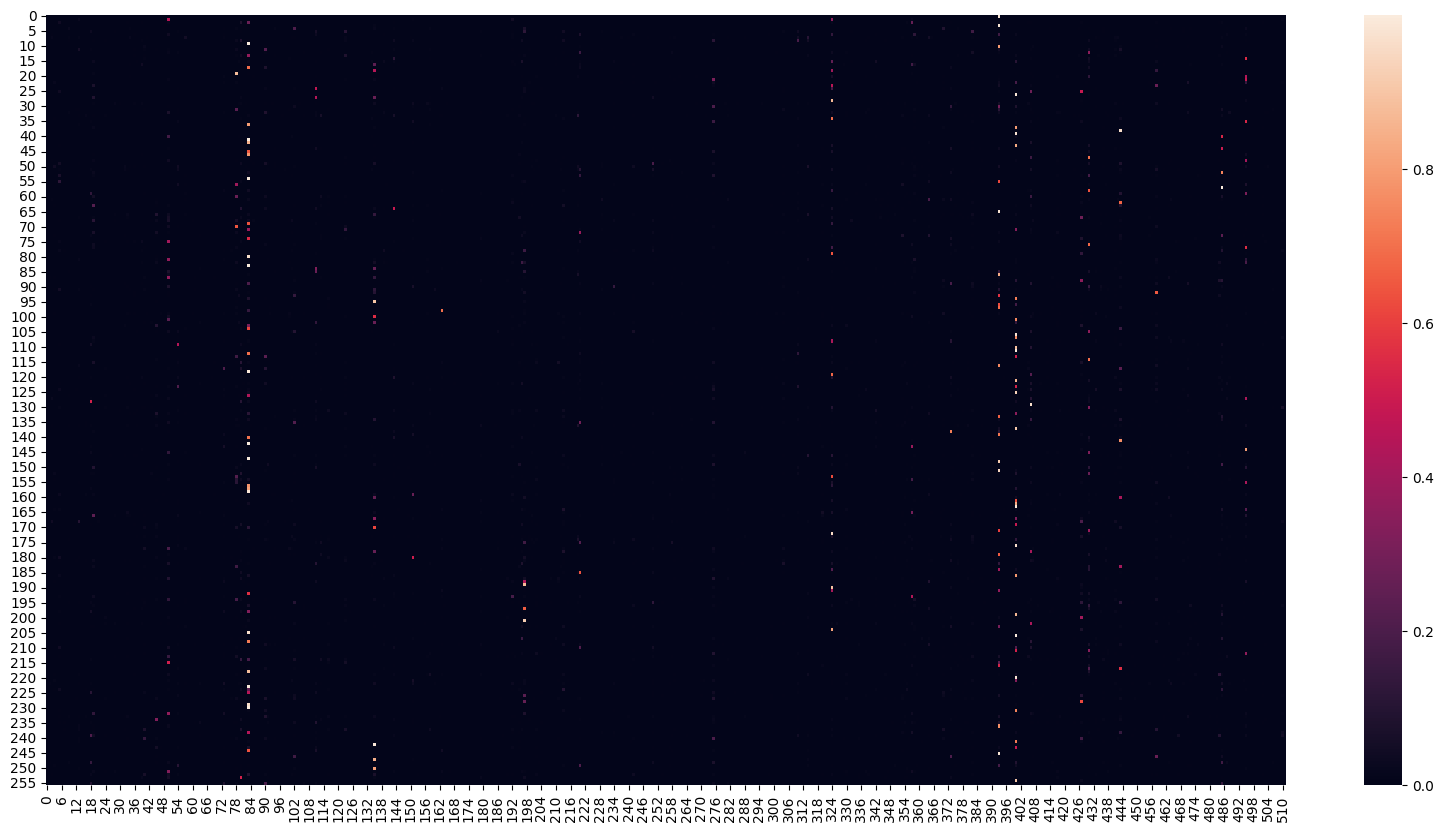

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
y, dots = layer(x)
plt.figure(figsize=(20, 10))
sns.heatmap(dots.detach().numpy())

In [1]:
import torch
from torch.nn import Linear

layer = Linear(8192, 8192*8)

In [25]:
from torch.profiler import profile, record_function, ProfilerActivity

x = torch.randn(1, 512, 8192) # B, N, C

with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
        layer(x)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=200))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        16.71%     117.000us       100.00%     700.000us     700.000us           0 b           0 b           0 b      -8.00 Mb             1  
                                           aten::linear         2.57%      18.000us        83.29%     583.000us     583.000us           0 b           0 b       8.00 Mb           0 b             1  
         

STAGE:2023-04-26 08:19:35 269111:269111 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-04-26 08:19:35 269111:269111 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-04-26 08:19:35 269111:269111 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [1]:
import torch
from modules import HKLinear2D, HKLinear

layer = HKLinear2D(8192, 8192*8, n_clusters=256)
layer.init_clusters()
# layer = torch.compile(layer)
layer = torch.jit.script(layer)

In [2]:
from torch.profiler import profile, record_function, ProfilerActivity

x = torch.randn(1, 512, 8192) # B, N, C
# layer = HKLinear(8192, 8192*8, n_clusters=16, threshold=0.05)
# layer.init_clusters()
layer.threshold=0.01

with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
        with torch.no_grad():
            layer(x)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=200))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        70.13%      37.527ms       100.00%      53.510ms      53.510ms           0 b           0 b           0 b    -128.00 Mb             1  
                                               defaults         0.01%       3.000us         0.01%       3.000us       0.429us           0 b           0 b           0 b           0 b             7  
         

STAGE:2023-04-26 08:18:38 269068:269068 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-04-26 08:18:39 269068:269068 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-04-26 08:18:39 269068:269068 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


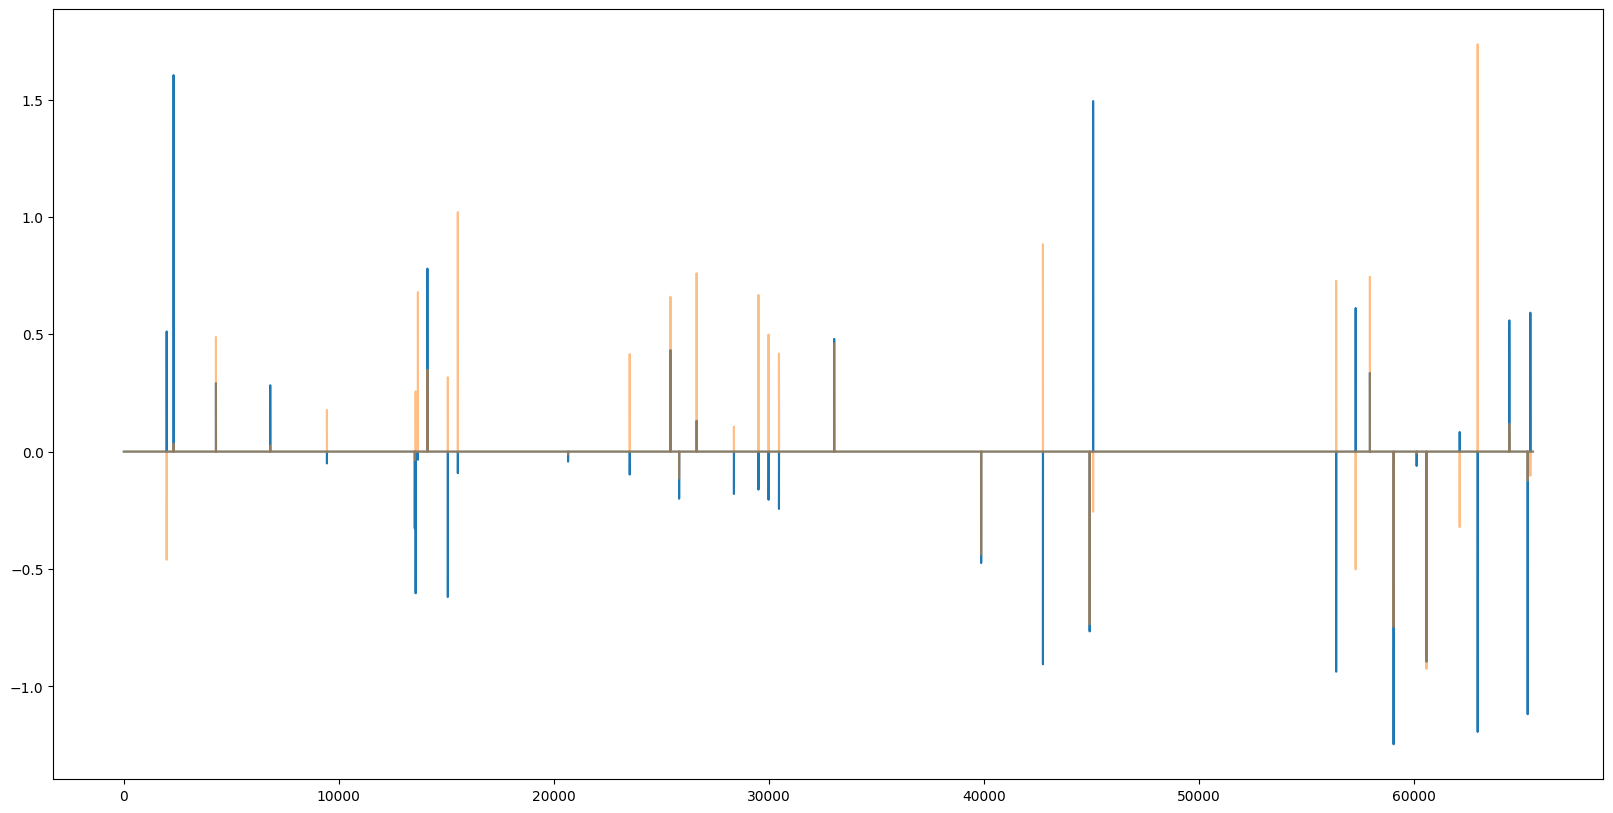

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(y[15,:].detach().cpu().numpy())
plt.plot(y[4,:].detach().cpu().numpy(), alpha=0.5)